# Modelo de Segmentação de Áreas Inundadas
## Bootcamp Machine Learning - Atlântico Avanti

Neste primeira etapa, o trabalho avaliou o dataset "Flood Area Segmentation" e teve como foco principal a análise exploratória dos dados disponíveis.

**Objetivo**: Apresentar informações do dataset

**Integrantes**:
- Adriana Bispo
- Alexandre Teixeira
- Anna Luiza Laudares
- Gabriel Oliveira
- Juliana Rodrigues
- Letícia Moreira

**Dataset disponível em**: [Kaggle](https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation?select=Image)

## 📚 Importando Bibliotecas e Dataset

In [ ]:
import os
import kagglehub
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hashlib
from collections import Counter
from PIL import Image
from pathlib import Path
from itertools import chain

dataset_path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

image_dir = os.path.join(dataset_path, "Image")
mask_dir = os.path.join(dataset_path, "Mask")

df = pd.read_csv(os.path.join(dataset_path,"metadata.csv"))

100%|██████████| 107M/107M [00:01<00:00, 58.2MB/s]

Extracting files...


## 🏸 Integridade dos Arquivos

### ■​ Verifique se todas as imagens estão no mesmo formato, ex: JPEG, PNG, etc.

O dataset possui duas colunas: uma denomida como “imagem” que possui imagens com formato Jpg e outra nomeada como “máscara” tendo imagens com o formato PNG.

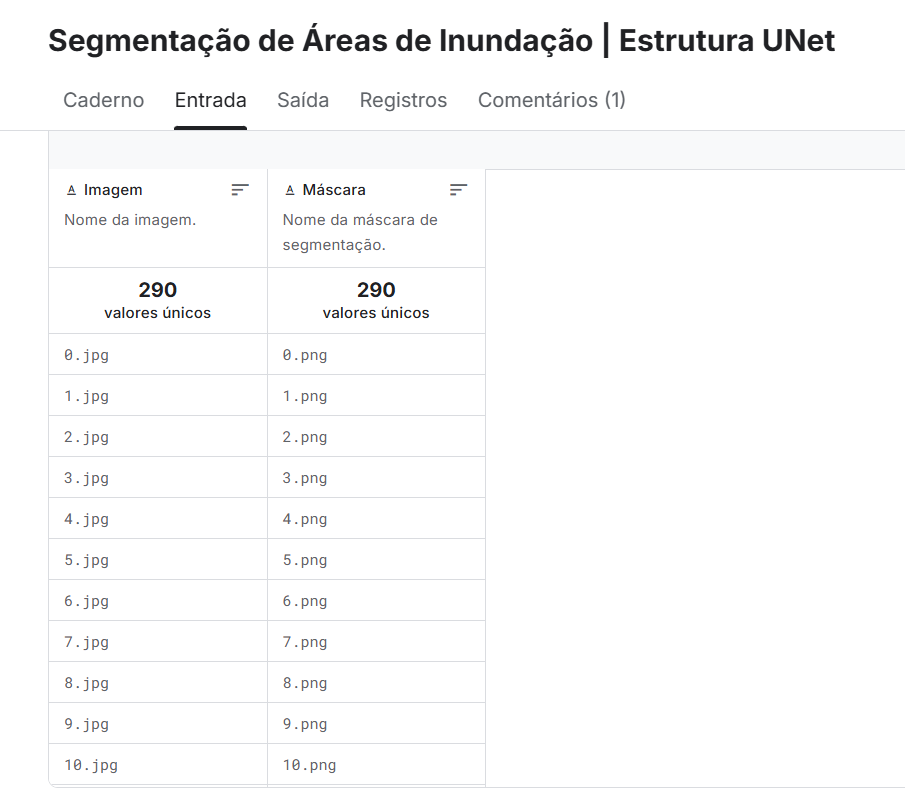

##🛠️ Qualidade das Imagens


### ■​ Verifique se todas as imagens listadas no arquivo de informações realmente existem no diretório de imagens e vice-versa e identifique imagens corrompidas que não podem ser abertas ou processadas


In [ ]:
def verify_images(directory, generate_hashes=False):
    corrupted_files = []
    valid_hashes = {}

    # Percorre os arquivos no diretório recursivamente
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)

            # Tratamento de exceções para leitura dos arquivos
            try:
                with open(file_path, 'rb') as f:
                    content = f.read()
                    if generate_hashes:
                        file_hash = hashlib.sha256(content).hexdigest() # Gera arquivo hash para cada imagem lida
                        valid_hashes[file] = file_hash # Armazena no dicionário
            except IOError:
                corrupted_files.append(file_path) # Armazena o caminho do arquivo se ele estiver corrompido
                continue

            # Tratamento de exceções para integridade do arquivo
            try:
                with Image.open(file_path) as img:
                    img.verify() # Verificação básica da integridade do arquivo
                with Image.open(file_path) as img:
                    img.load() # Carrega o arquivo na memória
                    img.transpose(Image.FLIP_LEFT_RIGHT) # Realiza testes adicionais de integridade
            except (IOError, OSError, Image.DecompressionBombError) as erro:
                corrupted_files.append(file_path) # Caso o arquivo esteja corrompido, adiciona o caminho dele em uma lista
                print(f"Arquivo corrompido: {file_path} - Erro: {str(erro)}") # Printa o código de erro para o arquivo corrompido

        #Retorno da função
        return {
            'total_files': len(files),
            'corrupted_files': corrupted_files,
            'valid_hashes': valid_hashes if generate_hashes else None
        }

if __name__ == "__main__":
    print(f"Verificando existência dos diretórios:")
    print(f"Diretório de imagens existe: {'✅Sim' if os.path.exists(image_dir) else '🔴Não'}")
    print(f"Diretório de máscaras existe: {'✅Sim' if os.path.exists(mask_dir) else '🔴Não'}")

    report_image = verify_images(image_dir, generate_hashes=True)
    report_mask = verify_images(mask_dir, generate_hashes=True)

    print()
    print("Relatório de Integridade:")
    print(f"Arquivos de imagem: {report_image['total_files']} verificados")
    print(f"Arquivos de máscara: {report_mask['total_files']} verificados")
    print(f"Total geral: {report_image['total_files'] + report_mask['total_files']} arquivos\n")

 # Integridade pasta Image
    if report_image['corrupted_files']:
        print("Lista de arquivos corrompidos:")
        for corrupted in report_image['corrupted_files']:
            print(f"🔴 - {corrupted}")
        print()
    else:
        print("✅Não foram encontrados arquivos da pasta Image corrompidos!\n")

    if report_image['valid_hashes']:
        print(f"✅Hashes válidos gerados para {len(report_image['valid_hashes'])} arquivos da pasta Image\n")

# Integridade pasta Mask
    if report_mask['corrupted_files']:
        print("Lista de arquivos corrompidos:")
        for corrupted in report_mask['corrupted_files']:
            print(f" - {corrupted}")
        print()
    else:
        print("✅Não foram encontrados arquivos da pasta Mask corrompidos!\n")

    if report_mask['valid_hashes']:
        print(f"✅Hashes válidos gerados para {len(report_mask['valid_hashes'])} arquivos da pasta Mask\n")

Verificando existência dos diretórios:
Diretório de imagens existe: ✅Sim
Diretório de máscaras existe: ✅Sim

Relatório de Integridade:
Arquivos de imagem: 290 verificados
Arquivos de máscara: 290 verificados
Total geral: 580 arquivos

✅Não foram encontrados arquivos da pasta Image corrompidos!

✅Hashes válidos gerados para 290 arquivos da pasta Image

✅Não foram encontrados arquivos da pasta Mask corrompidos!

✅Hashes válidos gerados para 290 arquivos da pasta Mask



## 📑Consistência dos Metadados


### ■​ Verifique se há valores ausentes nos metadados e como esses casos são tratados.

In [ ]:
import os
import pandas as pd

def verificar_imagens_metadata(image_dir, df):
    imagens = {f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))}

    try:
        df = pd.read_csv(os.path.join(dataset_path,"metadata.csv"))
        coluna_imagens = df.columns[0]
        metadados = set(df[coluna_imagens].astype(str))
    except Exception as e:
        print(f"Erro ao ler o arquivo de metadados: {e}")
        return

    imagens_sem_metadados = imagens - metadados

    if imagens_sem_metadados:
        print("\n🔴 As seguintes imagens não estão no arquivo de metadados:")
        for img in imagens_sem_metadados:
            print(f"   - {img}")
    else:
        print("\n✅ Todas as imagens estão no arquivo de metadados.")

verificar_imagens_metadata(image_dir, df)


✅ Todas as imagens estão no arquivo de metadados.


###■​ Verifique valores inconsistentes, por exemplo: dimensões de imagens fora do esperado.

1. Informações disponíveis no arquivo metadata

In [ ]:
# Caminho do arquivo de metadados (substitua pelo caminho correto)
metadados_path = df

# Carregar o arquivo CSV
try:
    df = pd.read_csv(os.path.join(dataset_path,"metadata.csv"))
    print("✅ Metadados carregados com sucesso!\n")

    # Exibir as primeiras linhas
    print("Amostra dos metadados:")
    print(df.head())

    # Exibir informações gerais
    print("\nInformações gerais:")
    print(df.info())

    # Exibir estatísticas descritivas
    print("\nEstatísticas descritivas:")
    print(df.describe())

    # Verificar valores NaN
    print("\nValores ausentes por coluna:")
    print(df.isnull().sum())

    # Verificar valores duplicados
    print("\nNúmero de linhas duplicadas:", df.duplicated().sum())

except FileNotFoundError:
    print(f"Erro: O arquivo {metadados_path} não foi encontrado.")

✅ Metadados carregados com sucesso!

Amostra dos metadados:
   Image   Mask
0  0.jpg  0.png
1  1.jpg  1.png
2  2.jpg  2.png
3  3.jpg  3.png
4  4.jpg  4.png

Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   290 non-null    object
 1   Mask    290 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB
None

Estatísticas descritivas:
           Image      Mask
count        290       290
unique       290       290
top     1087.jpg  1087.png
freq           1         1

Valores ausentes por coluna:
Image    0
Mask     0
dtype: int64

Número de linhas duplicadas: 0


2. Analisando as dimensões dos aquivos de imagens e máscaras



Total de imagens encontradas: 580
Imagens processadas: 579


<ipython-input-22-b7bb6b611864>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Dimensão_str', y='Frequência', data=plot_data, palette='viridis')


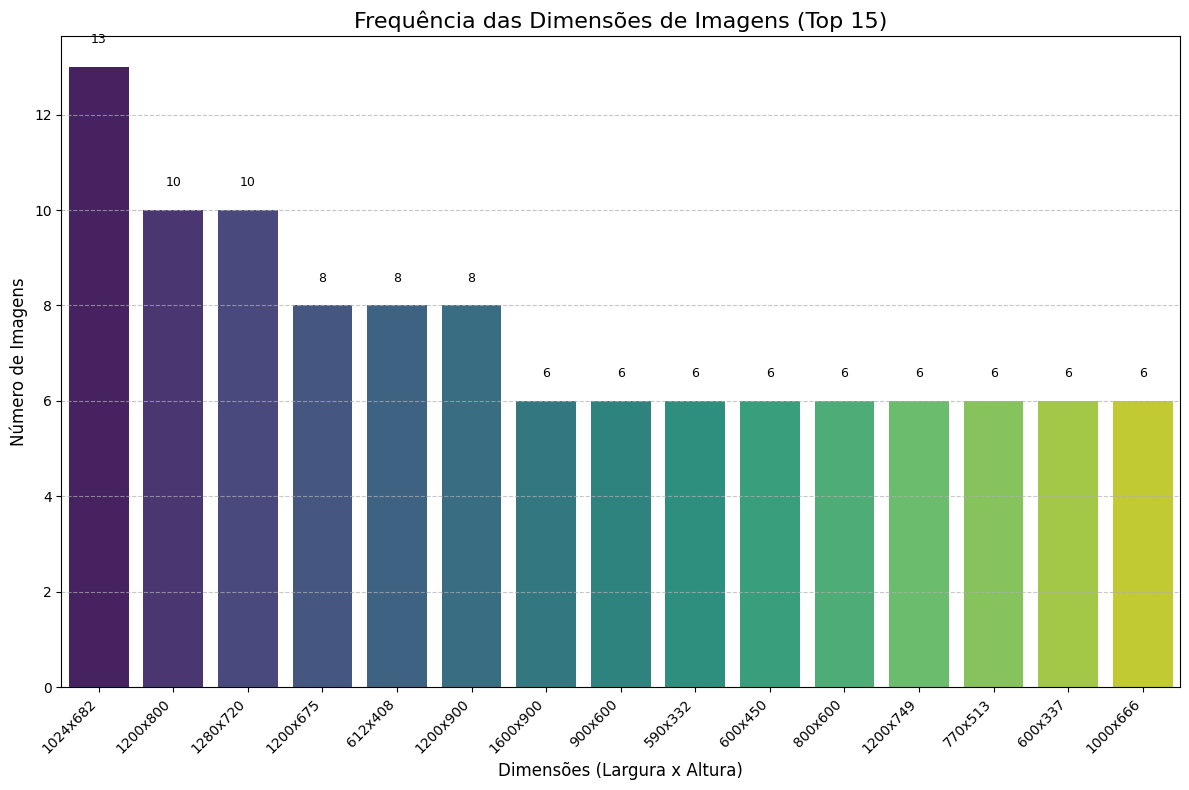

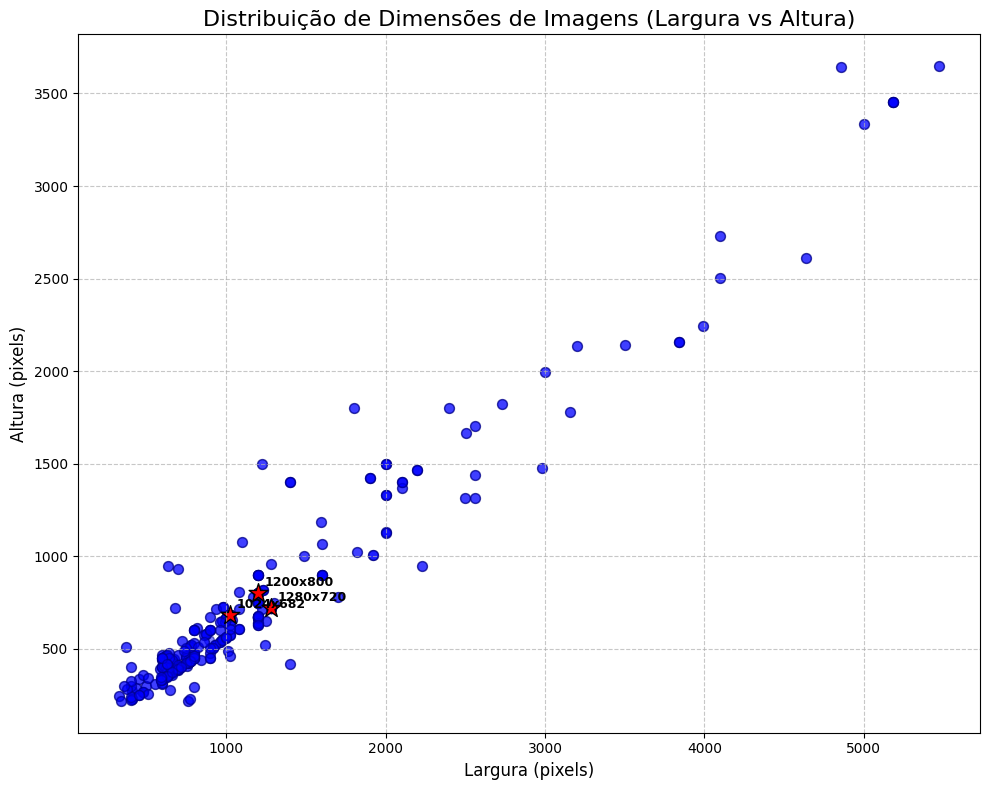


Frequência das dimensões das imagens:
Dimensão (Largura×Altura)  Frequência Área (pixels) Percentual
                 1024x682          13        698368      2.25%
                 1200x800          10        960000      1.73%
                 1280x720          10        921600      1.73%
                 1200x675           8        810000      1.38%
                  612x408           8        249696      1.38%
                 1200x900           8       1080000      1.38%
                 1600x900           6       1440000      1.04%
                  900x600           6        540000      1.04%
                  590x332           6        195880      1.04%
                  600x450           6        270000      1.04%
                  800x600           6        480000      1.04%
                 1200x749           6        898800      1.04%
                  770x513           6        395010      1.04%
                  600x337           6        202200      1.04%
                

In [ ]:
# Obter dimensões das imagens
dimensoes = []
dimensoes_str = []  # Para representação como string

# Função para encontrar todas as imagens no dataset
def encontrar_imagens(diretorio, extensoes=('.jpg', '.png', '.jpeg', '.bmp')):
    caminhos_imagens = []
    for raiz, _, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            if arquivo.lower().endswith(extensoes):
                caminhos_imagens.append(os.path.join(raiz, arquivo))
    return caminhos_imagens

# Encontrar todas as imagens
caminhos_imagens = encontrar_imagens(dataset_path)
print(f"Total de imagens encontradas: {len(caminhos_imagens)}")

for img_path in caminhos_imagens:
    img = cv2.imread(img_path)
    if img is not None:
        altura, largura = img.shape[:2]
        dimensoes.append((largura, altura))
        dimensoes_str.append(f"{largura}x{altura}")

print(f"Imagens processadas: {len(dimensoes)}")

# Verificar se temos dados para plotar
if not dimensoes:
    print("Nenhuma dimensão de imagem encontrada!")
else:
    # Contar frequências das dimensões
    contagem = Counter(dimensoes)

    # Criar DataFrame para análise
    df_contagem = pd.DataFrame(contagem.items(), columns=['Dimensão', 'Frequência'])
    df_contagem['Dimensão_str'] = df_contagem['Dimensão'].apply(lambda x: f'{x[0]}x{x[1]}')
    df_contagem = df_contagem.sort_values(by='Frequência', ascending=False)

    # Calcular área das imagens
    df_contagem['Área (pixels)'] = df_contagem['Dimensão'].apply(lambda x: x[0] * x[1])

    # Plotar distribuição de frequência das dimensões
    plt.figure(figsize=(12, 8))

    # Limitar para as 15 dimensões mais comuns para melhor visualização
    top_n = min(15, len(df_contagem))
    plot_data = df_contagem.head(top_n)

    # Criar barplot
    ax = sns.barplot(x='Dimensão_str', y='Frequência', data=plot_data, palette='viridis')

    # Adicionar rótulos e título
    plt.title('Frequência das Dimensões de Imagens (Top 15)', fontsize=16)
    plt.xlabel('Dimensões (Largura x Altura)', fontsize=12)
    plt.ylabel('Número de Imagens', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adicionar valores nas barras
    for i, v in enumerate(plot_data['Frequência']):
        ax.text(i, v + 0.5, str(v), ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Criar gráfico de dispersão para mostrar a relação entre largura e altura
    larguras, alturas = zip(*dimensoes)

    plt.figure(figsize=(10, 8))
    plt.scatter(larguras, alturas, alpha=0.5, s=50, c='blue', edgecolors='navy')

    # Destacar as 3 dimensões mais comuns
    top3_dims = df_contagem.head(3)['Dimensão'].tolist()
    for dim in top3_dims:
        plt.scatter(dim[0], dim[1], s=200, c='red', edgecolors='black', marker='*')
        plt.annotate(f"{dim[0]}x{dim[1]}",
                    (dim[0], dim[1]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=9,
                    fontweight='bold')

    plt.title('Distribuição de Dimensões de Imagens (Largura vs Altura)', fontsize=16)
    plt.xlabel('Largura (pixels)', fontsize=12)
    plt.ylabel('Altura (pixels)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Exibir tabela de contagem completa
    print("\nFrequência das dimensões das imagens:")

    # Preparar tabela para exibição
    display_df = df_contagem[['Dimensão_str', 'Frequência', 'Área (pixels)']].rename(
        columns={'Dimensão_str': 'Dimensão (Largura×Altura)'})

    # Adicionar percentual
    total = display_df['Frequência'].sum()
    display_df['Percentual'] = (display_df['Frequência'] / total * 100).round(2).astype(str) + '%'

    # Adicionar uma linha de somatória no final
    total_row = pd.DataFrame({
        'Dimensão (Largura×Altura)': ['Total'],
        'Frequência': [total],
        'Área (pixels)': ['-'],
        'Percentual': ['100%']
    })

    display_df = pd.concat([display_df, total_row], ignore_index=True)

    # Exibir a tabela
    print(display_df.to_string(index=False))

## 📊 Distribuição das Classes


###■​ Verifique a distribuição das classes para identificar possíveis desequilíbrios que possam afetar a modelagem

1. Caminhos para imagens, máscaras e metadados

4. Análise de uma máscara de exemplo


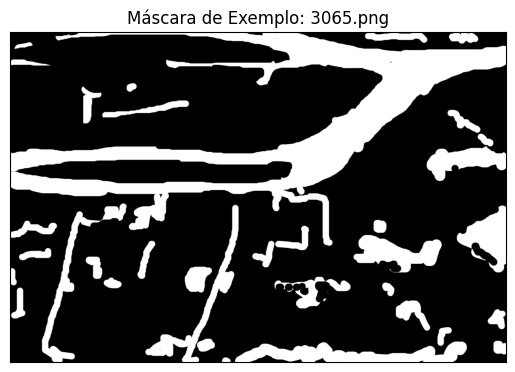

In [ ]:
mask_files = os.listdir(mask_dir)
example_mask_file = mask_files[0]
example_mask_dir = os.path.join(mask_dir, example_mask_file)
mask = cv2.imread(example_mask_dir, cv2.IMREAD_GRAYSCALE)

plt.imshow(mask, cmap='gray')
plt.title(f"Máscara de Exemplo: {example_mask_file}")
plt.xticks([])
plt.yticks([])
plt.show()

5. Função para analisar máscaras e contar pixels


In [ ]:
def analisar_mascara(caminho_mascara):
    """Conta pixels de inundação e não inundação."""
    mascara = np.array(Image.open(caminho_mascara))
    pixels_inundacao = np.sum(mascara == 1)
    pixels_nao_inundacao = np.sum(mascara == 0)
    return pixels_inundacao, pixels_nao_inundacao

6. Análise de todas as máscaras


In [ ]:
total_inundacao = 0
total_nao_inundacao = 0

for nome_arquivo in os.listdir(mask_dir):
    caminho_completo = os.path.join(mask_dir, nome_arquivo)
    inundacao, nao_inundacao = analisar_mascara(caminho_completo)
    total_inundacao += inundacao
    total_nao_inundacao += nao_inundacao

print(f"Total de pixels de inundação: {total_inundacao}")
print(f"Total de pixels de não inundação: {total_nao_inundacao}")

Total de pixels de inundação: 19064
Total de pixels de não inundação: 215482991


7. Histograma da distribuição de pixels


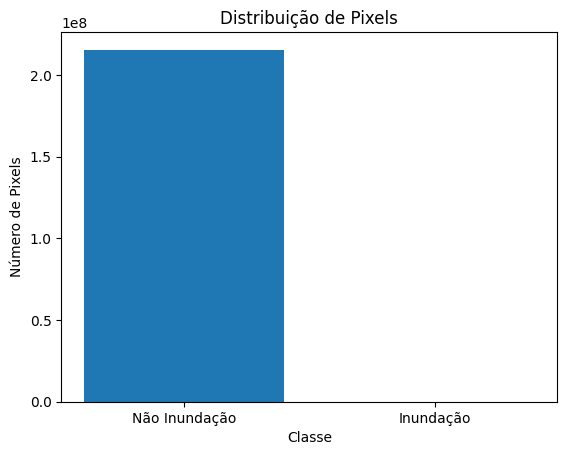

In [ ]:
plt.bar(['Não Inundação', 'Inundação'], [total_nao_inundacao, total_inundacao])
plt.title('Distribuição de Pixels')
plt.xlabel('Classe')
plt.ylabel('Número de Pixels')
plt.show()

## 🗂️ Duplicatas


###■​ Identifique imagens duplicadas que possam enviesar os resultados e  verifique duplicatas no arquivo de informações.

In [ ]:
def load_preprocess(image_dir):
    img = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    image_filename = Path(image_dir).name
    mask_path = Path(mask_dir) / image_filename

    if mask_path.exists():
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is not None and mask.shape == img.shape:
            img = cv2.bitwise_and(img, img, mask=mask)

    return img

def get_image_hash(image):
    resized = cv2.resize(image, (32, 32))
    dct = cv2.dct(np.float32(resized))
    dct_roi = dct[:8, :8]
    avg = np.mean(dct_roi)
    hash_value = (dct_roi > avg).astype(int)
    return hash_value.flatten()

image_extensions = ['*.jpg', '*.jpeg', '*.png']
image_files = list(chain.from_iterable(Path(image_dir).rglob(ext) for ext in image_extensions))

image_hashes = {}
for img_path in image_files:
    image = load_preprocess(str(img_path))
    if image is None:
        continue
    img_hash = get_image_hash(image)
    image_hashes[img_path] = img_hash

duplicates = []
image_keys = list(image_hashes.keys())

for i in range(len(image_keys)):
    for j in range(i + 1, len(image_keys)):
        hash1 = image_hashes[image_keys[i]]
        hash2 = image_hashes[image_keys[j]]
        hamming_dist = np.sum(hash1 != hash2)
        if hamming_dist < 10:
            duplicates.append((image_keys[i], image_keys[j], hamming_dist))

print("Imagens duplicadas encontradas:")
for img1, img2, dist in duplicates:
    if dist == 0:
        print(f"🔴 Imagens idênticas: {img1} e {img2}")


Imagens duplicadas encontradas:
🔴 Imagens idênticas: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/3033.jpg e /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/1041.jpg
🔴 Imagens idênticas: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/1012.jpg e /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/1057.jpg
🔴 Imagens idênticas: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/18.jpg e /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/1026.jpg
🔴 Imagens idênticas: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/29.jpg e /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/35.jpg
🔴 Imagens idênticas: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/43.jpg e /root/.cache/ka

##✅ Conclusões

✅ **Características dos dados:**

- Formato de imagens: as imagens estão em jpg e as máscaras estão no formato png, não havendo problemas ou discrepancias entre os formatos.

- Qualidade das imagens: não há imagens corrompidas no dataset e todas as imagens possuem sua respectiva máscara.

- Metadados: não há problemas de valores ausentes ou dados duplicados no arquivo de metadados.

🔴 **Considerações para a etapa de pré-processamento:**

- Imagens duplicadas: Há 10 imagens duplicadas no dataset.

- Distribuição irregular de classes: há muito mais áreas de "não inundação" que de "inundação" nas imagens utilizadas para o treinamento do modelo.
